# Experiment 2. Simultaneity analysis (Fig. 3E-H).

In [2]:
# importing prerequisites
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon
import matplotlib.pyplot as plt
import matplotlib
import pymc as pm
%matplotlib inline

### Loading imported data and  marking individual events as belonging to a group of simultaneous events

In [6]:
### loading raw data and estimate from the physically disappearing displays
responses= pd.read_csv(os.path.join('Experiment 2', 'Experiment2_Response.csv'), sep=';')
FOA= pd.read_csv(os.path.join('Experiment 2', 'Experiment2_FOA_Estimate.csv'), sep=';')

In [8]:
### marking individual events as belonging to a group of simultaneous events (or not!)

# throwing away all block start-end events
results= responses[responses.Event<100]
results['SimCount']= 0
for current_observer in results.ID.unique():
    print('%s'%(current_observer), end=' ')
    for current_block in results[results.ID==current_observer].Block.unique():
        iBlockTrials= results[(results.ID==current_observer) & (results.Block==current_block)].index
        for iTrial, iRow in enumerate(iBlockTrials):
            ## checking if this is still is an unassigned event
            if results.SimCount[iRow]!= 0:
                continue
            
            ## figuring out how many consecutive events of the same type can we have
            event_time= []
            for iConsecutiveEvent in range(2):
                if (iConsecutiveEvent+iTrial>=len(iBlockTrials)) or (results.Event[iRow]!=results.Event[iRow+iConsecutiveEvent]):
                    break
                event_time.append(results.Time[iRow+iConsecutiveEvent])
            
            ## trying for twos
            if len(event_time)>=2:
                dT= event_time[1]-event_time[0]
                iBracket= FOA[(FOA.ID==current_observer) & (FOA.Event==results.Event[iRow])].index
                if len(iBracket)>0 and dT>=FOA.MinRT[iBracket].values[0] and dT<=FOA.MaxRT[iBracket].values[0]:
                    # Match! Fill out and skip the rest of the loop
                    for iConsecutiveEvent in range(2):
                        results.set_value(iRow+iConsecutiveEvent, 'SimCount', 2)
                    continue
            
            ## single event, oh, well...
            results.set_value(iRow, 'SimCount', 1)
    print('\r', end= '')

E:\Programs\WinPython-32bit-3.5.2.2\python-3.5.2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
### computing fraction of simultaneous events

# relevant conditions
relevant_conditions= ['1 mask', '2 masks', '1 mask_connected dots', '2 masks_connected dots']

FractionOfSim= results[results.ConditionLabel.isin(relevant_conditions)].groupby(['ID', 'ConditionLabel']).apply(
    lambda x: pd.Series({
            'SimFraction': np.sum(x.SimCount>1)/len(x.SimCount)
        })).reset_index()

### converting table to a matrix, normalizing each observer to their overall means, but adding the overall average to keep condition means correct
matrix_like_df= FractionOfSim.pivot(index='ID', columns= 'ConditionLabel', values='SimFraction').reset_index()
fraction_matrix= np.array(matrix_like_df)[:, 1:].astype(float)
fraction_matrix[np.isnan(fraction_matrix)]= 0

## Adjusting observers' means following Loftus & Masson (1994)
observer_average= np.mean(fraction_matrix, axis=1)
condition_average= np.mean(fraction_matrix, axis=0)
adjusted_matrix= fraction_matrix-np.tile(observer_average, (4, 1)).T+np.tile(np.mean(fraction_matrix), (observer_average.shape[0], 4))
adjusted_matrix= adjusted_matrix.astype(float)
condition_labels= np.array(matrix_like_df.columns[1:])

### Using Bayesian approach to fit linear regression: 
1. Intercept + individual factors
2. Intercept + individual factors + **interaction**

In [13]:
# factors presence for each condition
Connected= np.array([0, 1, 0, 1]) # connectedness factor
Mask= np.array([1, 1, 0, 0]) # mask factor

# data and data shape (for forming the fitted data)
data_shape= (adjusted_matrix.shape[0],1)
data=adjusted_matrix

# variance around the linear regressor
sigma = pm.Exponential('sigma', beta=1.) 

# regression parameters
intercept     = pm.Uniform('intercept', -1e20, 1e20, value=0.5)
factorConnected= pm.Uniform('factorConnected', -1e20, 1e20)
factorMask  = pm.Uniform('factorMask', -1e20, 1e20)
factorBoth= pm.Uniform('factorBoth', -1e20, 1e20)
 
@pm.deterministic(plot=False)
def linear_fit_interaction(intercept=intercept, factorConnected=factorConnected, factorMask=factorMask, factorBoth=factorBoth, Connected=Connected, Mask=Mask, data_shape=data_shape):
    return np.tile(intercept+factorConnected*Connected+factorMask*Mask+factorBoth*(Connected & Mask), data_shape)

@pm.deterministic(plot=False)
def linear_fit_factors(intercept=intercept, factorConnected=factorConnected, factorMask=factorMask, Connected=Connected, Mask=Mask, data_shape=data_shape):
    return np.tile(intercept+factorConnected*Connected+factorMask*Mask, data_shape)

# defining models
yInteraction = pm.Normal('yInteraction', mu=linear_fit_interaction, tau=1.0/sigma**2, value=adjusted_matrix, observed=True)
modelInteraction = pm.Model([yInteraction, sigma, intercept, factorConnected, factorMask, factorBoth])
 
yFactors = pm.Normal('yFactors', mu=linear_fit_factors, tau=1.0/sigma**2, value=adjusted_matrix, observed=True)
modelFactors = pm.Model([yFactors, sigma, intercept, factorConnected, factorMask])

# running MCMCs
print('Independent factors:')                   
map_ = pm.MAP(modelFactors)
map_.fit()
mcmcFactors = pm.MCMC(modelFactors)
mcmcFactors.sample(120000, 100000, 2)
print()

print('Interaction:')                   
map_ = pm.MAP(modelInteraction)
map_.fit()
mcmcInteraction = pm.MCMC(modelInteraction)
mcmcInteraction.sample(120000, 100000, 2)                   
print()

Independent factors:
 [-----------------100%-----------------] 120000 of 120000 complete in 36.7 sec
Interaction:
 [-----------------100%-----------------] 120000 of 120000 complete in 37.8 sec


### Using fitted interaction model to predict values

In [14]:
### computing mean ± S.E.M. of predicted values for each condition

# getting posterior distributions for individual factors and their interaction  
InterceptDist= mcmcInteraction.trace('intercept')[:]
ConnectedDist= mcmcInteraction.trace('factorConnected')[:]
MaskDist= mcmcInteraction.trace('factorMask')[:]
BothDist= mcmcInteraction.trace('factorBoth')[:]

# factors presence for each condition
Connected= np.array([0, 1, 0, 1]) # connection factor 
Mask= np.array([1, 1, 0, 0]) # mask factor

# preparing arrays
predicted_mean= np.zeros(Connected.shape)
predicted_sem= np.zeros(Connected.shape)

# linear fit with an interaction term
def linear_fit_with_interaction(intercept, factorConnected, factorMask, factorBoth, Connected, Mask):
    return intercept+factorConnected*Connected+factorMask*Mask+factorBoth*(Connected & Mask)

# computing distribution of predicted values for each condition
for iCond in range(len(Connected)):
    current_condition_dist= linear_fit_with_interaction(InterceptDist, ConnectedDist, MaskDist, BothDist, Connected[iCond], Mask[iCond])
    predicted_mean[iCond]= np.mean(current_condition_dist)
    predicted_sem[iCond]= np.std(current_condition_dist)

### Plotting the experimental results and model fits alongside with posterior distributions for individual factors and their combination (Fig. 3E-H in the manuscript).

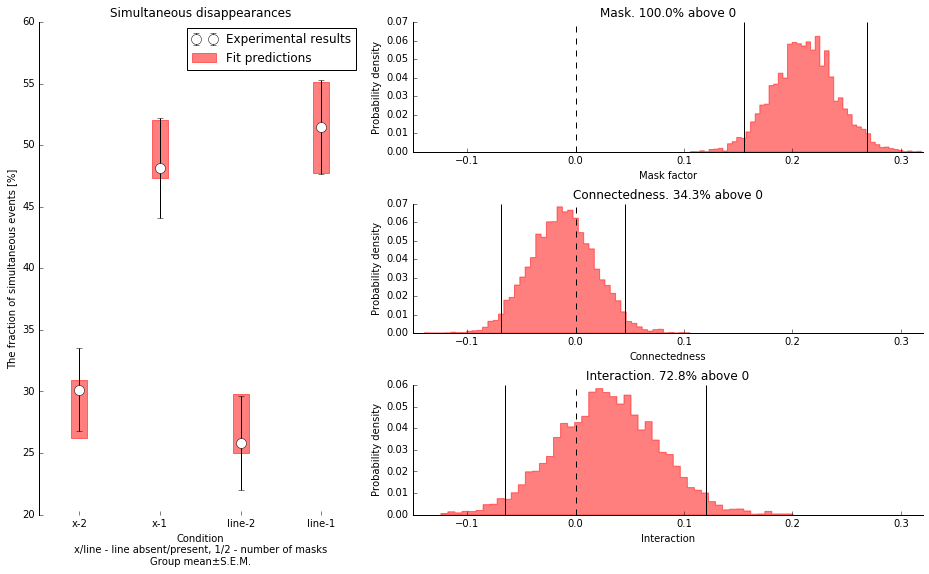

In [15]:
### plotting results
condition_order= [1, 3, 0, 2]
condition_full_labels= ['x-1', 'line-1', 'x-2', 'line-2']


matplotlib.rcParams['figure.figsize'] = (13.0, 8.0)
ax= plt.subplot2grid((6,5), (0, 0), colspan=2, rowspan=6)

data_plot= plt.errorbar(condition_order, 
             np.mean(adjusted_matrix, axis=0)*100,
             yerr=sem(adjusted_matrix)*100,
             fmt= 'ko',
             markersize= 10,
             markerfacecolor = 'white')

for iCond in range(len(predicted_mean)):
    fit_plot= plt.fill_between(condition_order[iCond]+np.array([-0.1, 0.1]),
                     100*(predicted_mean[iCond]-predicted_sem[iCond]+np.zeros((2, ))),
                     100*(predicted_mean[iCond]+predicted_sem[iCond]+np.zeros((2, ))),
                     facecolor='red', edgecolor= 'red', alpha= 0.5)
                     
plt.xticks(condition_order, condition_full_labels)
current_axis= plt.axis()
plt.axis([-0.5, 3.5, current_axis[2], current_axis[3]])
plt.legend(handles= [data_plot, fit_plot], labels=['Experimental results', 'Fit predictions'])
plt.ylabel('The fraction of simultaneous events [%]')
plt.xlabel('Condition\nx/line - line absent/present, 1/2 - number of masks\nGroup mean±S.E.M.')
plt.title('Simultaneous disappearances')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax= plt.subplot2grid((6,5), (0, 2), colspan=3, rowspan=2)
plt.hist(MaskDist, bins=50, histtype="stepfilled", weights=np.ones(MaskDist.shape)/MaskDist.shape[0], color='red',  edgecolor= 'red', alpha= 0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(MaskDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Mask. %.1f%% above 0'%(100*np.sum(MaskDist>0)/MaskDist.shape[0]))
plt.ylabel('Probability density')
plt.xlabel('Mask factor')
plt.axis([-0.15, 0.32, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax= plt.subplot2grid((6,5), (2, 2), colspan=3, rowspan=2)
plt.hist(ConnectedDist, bins=50, histtype="stepfilled", weights=np.ones(ConnectedDist.shape)/ConnectedDist.shape[0], color='red',  edgecolor= 'red', alpha= 0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(ConnectedDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Connectedness. %.1f%% above 0'%(100*np.sum(ConnectedDist>0)/ConnectedDist.shape[0]))
plt.ylabel('Probability density')
plt.xlabel('Connectedness')
plt.axis([-0.15, 0.32, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax= plt.subplot2grid((6,5), (4, 2), colspan=3, rowspan=2)
plt.hist(BothDist, bins=50, histtype="stepfilled", weights=np.ones(BothDist.shape)/BothDist.shape[0], color='red',  edgecolor= 'red', alpha= 0.5)
current_axis= plt.axis()
plt.vlines(np.percentile(BothDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Interaction. %.1f%% above 0'%(100*np.sum(BothDist>0)/BothDist.shape[0]))
plt.ylabel('Probability density')
plt.xlabel('Interaction')
plt.axis([-0.15, 0.32, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()
plt.show()